## INFO 2950 Final Project
### Introduction
**Research Questions:** 
1. Explore the socioeconomic and environmental features that best predict the incidents of hate crime incidents in the United States.
2. Investigate whether the addition of Covid-19 into our prediction model improves the model’s overall fitness.


In [99]:
import numpy as np
from numpy import sqrt, mean, absolute
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
import geopandas

### Exploratory Data Analysis
**Data Cleaning/Processing**
1. hate crime incidents
   
   *Clean Excel format* - Delete titles, merged cells, and footers; Renamed columns and indexes to a same standard across all years; Replace NaNs with zeros
   
   *Process* - Add [Incidents] column = the sum of all catogories of incidnets on that row; Add [Year] column; Drop all other columns except for [State]

In [100]:
# Import annual hate crime incidents df
years = np.linspace(2006, 2020, 15, dtype=int).tolist()
offenses =[]
for y in years:
    n = y - 2006
    offenses_path='./offenses_csv/%s.csv'%(y)
    offenses.append(pd.read_csv(offenses_path, thousands=','))
    
    # Add Year column
    offenses[n]['Year'] = y

# Combine all years' incidents data
df_off = pd.concat(offenses)

# Drop details because we only care about total
df_off = df_off[df_off['Agency type'] == 'Total']
df_off = df_off.drop(columns=['Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Agency name', 'Agency type',
'1st\r\nquarter', '2nd\r\nquarter', '3rd\r\nquarter', '4th\r\nquarter','Unnamed: 3', 'Unnamed: 9', 'Agency unit', 'Population1'])

# Replace NaNs with zeros
df_off = df_off.replace(np.nan,0)

# Replace exisiting str zero with float
cat_list=['Race', 'Religion', 'Sexual_orientation', 'Ethnicity', 'Disability', 'Gender', 'Gender_identity', 'Race/Ethnicity/Ancestry']
df_off[cat_list] = df_off[cat_list].astype(int)

# Add up total incidents
df_off['Incidents'] = 0
for c in cat_list:
    df_off['Incidents'] += df_off[c]

# Get rid of categories because we only care about total
df_off = df_off.drop(columns=cat_list)

# Clean State format
df_off['State'] = df_off['State'].str.capitalize()
df_off['Year'] = df_off['Year'].astype(str)
df_off = df_off.reset_index(drop=True)
df_off

,State,Year,Incidents
0,Alabama,2006,1
1,Alaska,2006,6
2,Arizona,2006,149
3,Arkansas,2006,113
4,California,2006,1297
...,...,...,...
742,Virginia,2020,170
743,Washington,2020,462
744,West virginia,2020,54
745,Wisconsin,2020,72


2. population
   
   *Clean* - Combine data of 2001-2010 and 2010-2020
   
   *Process* - Select only total population; Drop subcatrgories; Melt wide [Year] to tidy (each rows represents one year one state)

In [101]:
pop1 = pd.read_csv('./pop1.csv', thousands=',')

# Trun wide df to tidy
pop1 = pd.melt(pop1, id_vars=['State'], value_vars=pop1.columns[1:], var_name='Year', value_name='Population')
# pop1

In [102]:
pop2 = pd.read_csv('./pop2.csv', thousands=',')

# Select totol by setting all categorical inputs to zero
col =['SEX', 'ORIGIN', 'RACE', 'AGEGRP']
for c in col:
    pop2 = pop2[pop2[c] == 0]

pop2 = pop2.drop(columns=col)
# Trun wide df to tidy
pop2 = pd.melt(pop2, id_vars=['State'], value_vars=pop2.columns[1:], var_name='Year', value_name='Population')
# pop2

In [103]:
# Combine population data (2010-2020) and (2000-2009)
df_pop = pd.concat([pop2, pop1])
df_pop

,State,Year,Population
0,Alabama,2000,4447207
1,Alaska,2000,626933
2,Arizona,2000,5130247
3,Arkansas,2000,2673293
4,California,2000,33871653
...,...,...,...
567,Washington,2020,7693612
568,West Virginia,2020,1784787
569,Wisconsin,2020,5832655
570,Wyoming,2020,582328


3. GDP

   *Process* - melt wide [Year] to tidy (each rows represents one year one state)

In [104]:
df_gdp = pd.read_csv('./gdp.csv', thousands=',')

# Trun wide df to tidy
df_gdp = pd.melt(df_gdp, id_vars=['State'], value_vars=df_gdp.columns[1:], var_name='Year', value_name='GDP')
# df_gdp

4. avergae temperature
   
   *Clean* - Change column names to the same standard as above
   
   *Process* - Add [State] and [Year] column; Drop other columns; Combine all states' data

In [105]:
# read all csv in temperature folder
path = './avg_temp'
csv_files = glob.glob(path + '/*.csv')

dfs = []
for f in csv_files:
    df = pd.read_csv(f)

    # Get State column
    parts = f.split('/')
    part = parts[2].split('.')
    df['State'] = part[0]

    # Formatting 
    df['Temperature'] = df['Value']
    df['Year'] = (df['Date']/100).astype(int).astype(str)
    df = df.drop(columns=['Date', 'Value', 'Anomaly'])

    # Combine all avg_temp df
    dfs.append(df)

df_temp = pd.concat(dfs).reset_index(drop=True)
df_temp

,State,Temperature,Year
0,Georgia,64.0,2004
1,Georgia,63.8,2005
2,Georgia,64.5,2006
3,Georgia,64.8,2007
4,Georgia,63.5,2008
...,...,...,...
828,Rhode Island,52.2,2016
829,Rhode Island,51.5,2017
830,Rhode Island,51.6,2018
831,Rhode Island,50.6,2019


In [106]:
df_marr = pd.read_csv('./marr.csv', thousands=',')
df_marr['State'] = df_marr['Unnamed: 0']
df_marr = df_marr.drop(columns=['Unnamed: 0', 'Unnamed: 25'])
df_marr = df_marr.replace('---',0)
df_marr = pd.melt(df_marr, id_vars=['State'], value_vars=df_marr.columns[:-1], var_name='Year', value_name='Marriage_Rate')

def replace(s):
    df = df_marr.loc[df_marr['State']==s]
    df_ = df.reset_index(drop=True)
    reg = LinearRegression().fit(df[['Year']], df['Marriage_Rate'])
    pred = reg.predict(df[['Year']])
    big_l = df[df['Marriage_Rate']==0].index.to_list()
    small_l = df_[df_['Marriage_Rate']==0].index.to_list()

    for i, l in enumerate(big_l):
        df_marr.loc[l, 'Marriage_Rate'] = pred[small_l[i]]

states = ['Georgia', 'Louisiana', 'Oklahoma']
for s in states: replace(s)

df_marr['Year'] = df_marr['Year'].astype(str)
df_marr['Marriage_Rate'] = df_marr['Marriage_Rate'].astype(float)
df_marr.to_csv('marriage.csv')
df_marr

,State,Year,Marriage_Rate
0,Alabama,2020,7.2
1,Alaska,2020,5.7
2,Arizona,2020,4.9
3,Arkansas,2020,7.8
4,California,2020,3.2
...,...,...,...
1219,Virginia,1990,11.4
1220,Washington,1990,9.5
1221,West Virginia,1990,7.2
1222,Wisconsin,1990,7.9


In [107]:
df_edu = pd.read_csv('./edu.csv', thousands=',')
df_edu = pd.melt(df_edu, id_vars=['Year'], value_vars=df_edu.columns[1:], var_name='State', value_name='Education_Rate')
df_edu['Year'] = df_edu['Year'].astype(str)
df_edu

,Year,State,Education_Rate
0,2006,Alabama,26.9
1,2007,Alabama,26.0
2,2008,Alabama,27.3
3,2009,Alabama,26.6
4,2010,Alabama,27.9
...,...,...,...
795,2017,Wyoming,27.6
796,2018,Wyoming,26.9
797,2019,Wyoming,29.1
798,2020,Wyoming,28.2


Model DataFrame

- Combine four variables above
- *Transformation* - change population and GDP to log scale; add binary covid indicator

In [108]:
# Combine all input features and the output
df = df_pop.merge(df_gdp, on=['State', 'Year'])
df = df.merge(df_off, on=['State', 'Year'])
df = df.merge(df_temp, on=['State', 'Year'])
df = df.merge(df_marr, on=['State', 'Year'])
df = df.merge(df_edu, on=['State', 'Year'])
df['Year'] = df['Year'].astype(int)

# Log transformation
df['Log_Population'] = np.log(df['Population'])
df['Log_GDP'] = np.log(df['GDP'])

# Add covid indicator (binary)
df['Is_Covid'] = np.where(df['Year']==2020, 1, 0)
df.to_csv('model.csv')
df

,State,Year,Population,GDP,Incidents,Temperature,Marriage_Rate,Education_Rate,Log_Population,Log_GDP,Is_Covid
0,Alabama,2006,4628981,187270.8,1,64.2,9.2,26.9,15.347847,12.140311,0
1,Alaska,2006,675302,49190.2,6,26.4,8.2,21.1,13.422915,10.803450,0
2,Arizona,2006,6029141,274179.4,149,61.1,6.5,18.2,15.612115,12.521538,0
3,Arkansas,2006,2821761,108460.6,113,62.0,12.4,25.5,14.852872,11.594142,0
4,California,2006,36021202,2002437.4,1297,58.6,6.3,29.0,17.399618,14.509876,0
...,...,...,...,...,...,...,...,...,...,...,...
573,Vermont,2020,623347,29064.6,60,44.8,6.0,42.0,13.342859,10.277276,1
574,Virginia,2020,8590563,478909.3,170,57.4,5.3,42.1,15.966175,13.079267,1
575,Washington,2020,7693612,538856.1,462,48.1,4.8,38.4,15.855901,13.197204,1
576,Wisconsin,2020,5832655,293104.9,72,44.8,4.5,23.1,15.578983,12.588286,1


**Data Description**

- Grain (instance): each row represents per year and per state
- Limitations: Limited year range 2006 -2020; Replaced NaN with zero
- Output: Incidents; Inputs(Features): Temperature, Log_Population Log_GDP, Is_Covid 

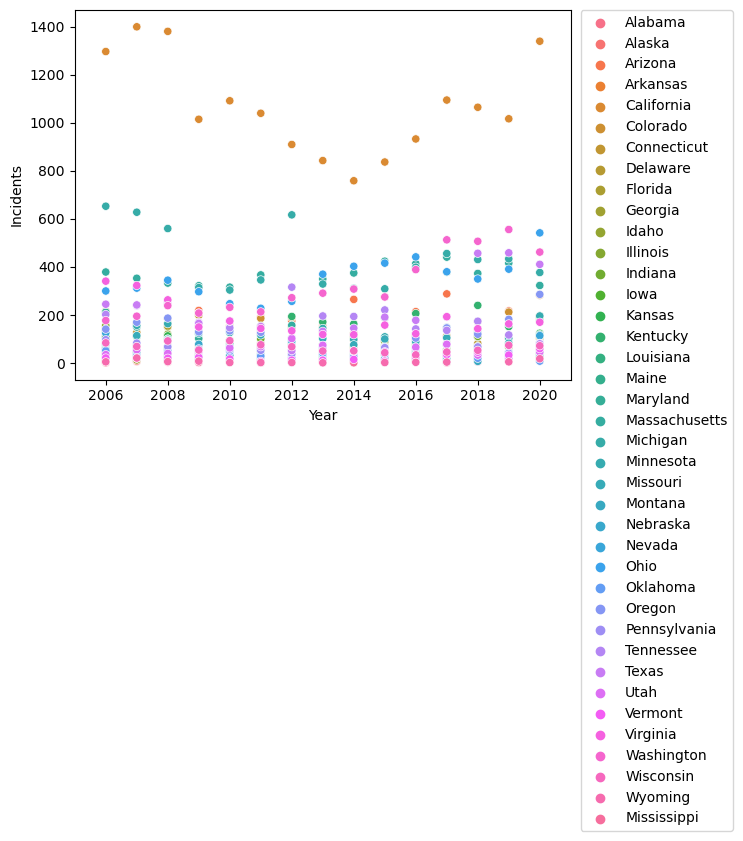

In [109]:
# Plot scatter plot Incidents X Year
ax = sns.scatterplot(data=df, x='Year', y='Incidents', hue='State')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlim(2005,2021)
plt.show()

In [110]:
df.iloc[:,5:].corr()

,Temperature,Marriage_Rate,Education_Rate,Log_Population,Log_GDP,Is_Covid
Temperature,1.000000,-0.027163,-0.159953,0.539104,0.471998,0.026060
Marriage_Rate,-0.027163,1.000000,-0.064250,-0.158412,-0.176675,-0.087778
Education_Rate,-0.159953,-0.064250,1.000000,-0.065190,-0.021594,0.226424
Log_Population,0.539104,-0.158412,-0.065190,1.000000,0.981931,0.009591
Log_GDP,0.471998,-0.176675,-0.021594,0.981931,1.000000,0.016963
Is_Covid,0.026060,-0.087778,0.226424,0.009591,0.016963,1.000000


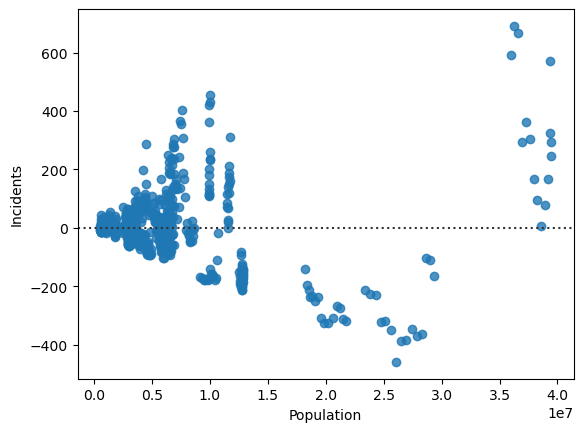

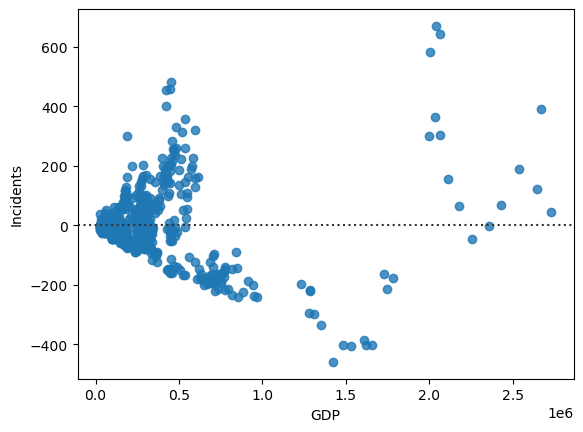

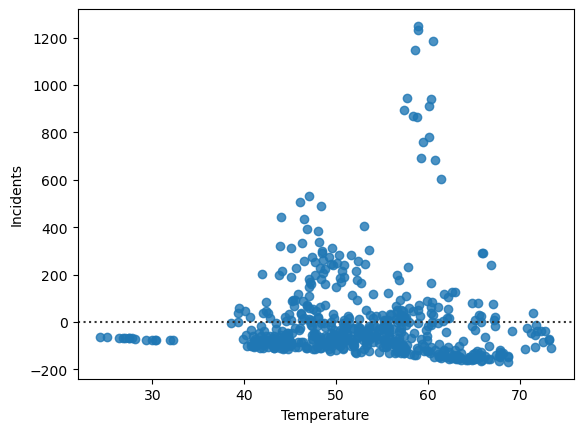

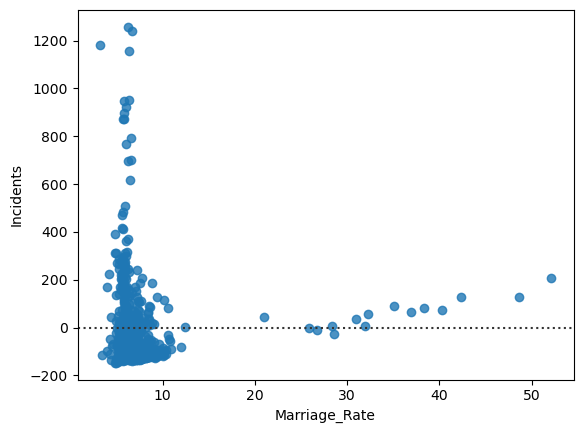

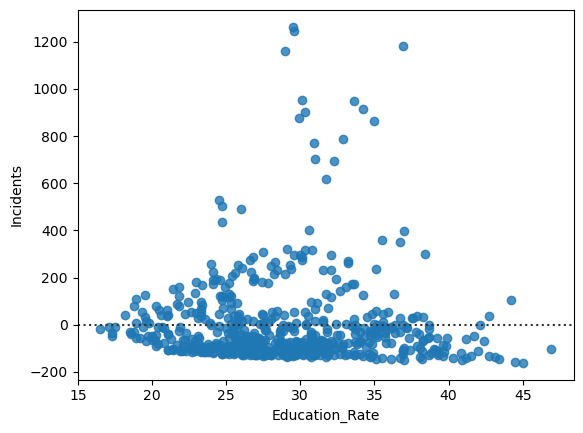

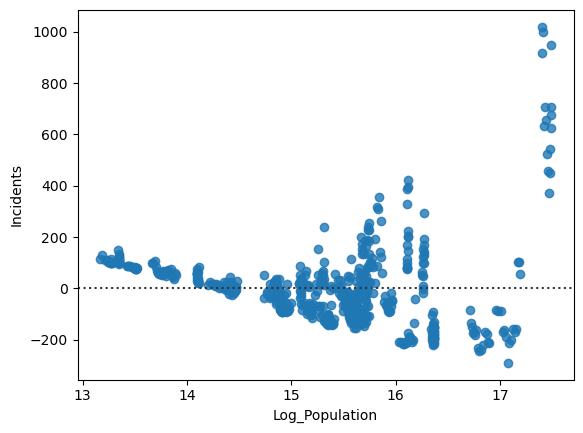

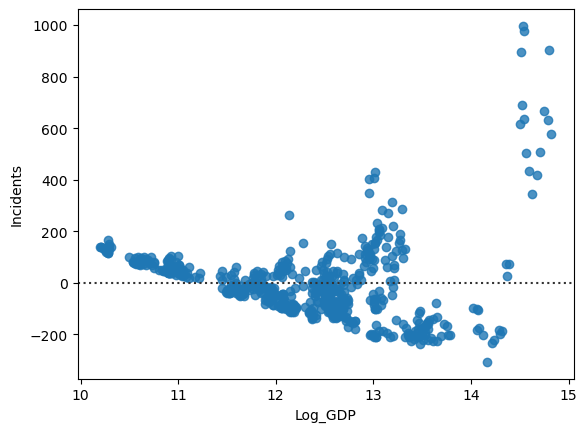

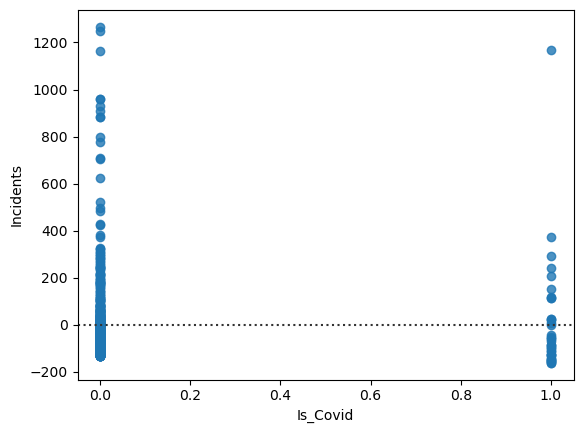

In [111]:
var = df.columns[[2,3,5,6,7,8,9,10]]
for v in var:
    # sns.residplot(data=df, x='Year', y=v)
    sns.residplot(data=df, x=v, y='Incidents')
    plt.show()

### Preregistration statement
**Hypothesis 1**

Null: None of the predictor variables is useful in terms of predicting the number of state-wise hate crime incidents.
β(population) =  β(GDP) = β(temperature) = 0 in all combinations of inputs.

Alternative: At least one of the predictor variables (population, GDP, temperature) is useful in terms of predicting the number of state-wise hate crime incidents.
βi ≠ 0 (for i = population, GDP, temperature) in any one combination of inputs.

**Hypothesis 2**

Null: On top of the model above, before Covid or after doesn’t affect the number of state-wise hate crime incidents.
β (is_covid)  = 0  

Alternative: Incidents of state-wise hate crimes increase with the presence of Covid.
β (is_covid) ≠ 0

### Data analysis & Evaluation of significance

**Hypothesis 1 Data analysis**

*Single variable models* 
- very small p-values, < 0.05, significant
- β(population) ≠  0, β(GDP) ≠ 0, β(temperature) ≠ 0 


In [112]:
var = ['Temperature', 'Log_GDP', 'Marriage_Rate', 'Education_Rate']
train, test= train_test_split(df, test_size=0.1)
inc = train['Incidents']

# Anova F test for single variable selection
def anova(var):
    f = 'Incidents ~ ' + var
    d = smf.ols(formula=f, data=train)
    model = d.fit()
    a = sm.stats.anova_lm(model)
    print(a)

# Log likelihood ratio test for further models selection
def llr(base, add):
    X = train[add]
    model = sm.OLS(inc, X).fit()
    likelihood_ratio = -2*(base.llf - model.llf)
    log_likelihood_ratio = scipy.stats.chi2.sf(likelihood_ratio, 2)
    print(str(add) +'LLR = '+ str(log_likelihood_ratio))

# Regression summary including coefficients and p-values
def summary(input):
    X = test[input]
    reg = sm.OLS(test['Incidents'], X).fit()
    print(reg.summary())

# KFold to verify variable selection
def kfold(input):
    kf = KFold(n_splits=5, shuffle=True)
    X = train[input]
    reg = LinearRegression()
    scores = cross_val_score(reg, X, inc, scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1)
    acc = cross_val_score(reg, X, inc, cv=kf)
    m = sqrt(mean(absolute(scores)))
    print('KFold'+str(input)+': ')
    print('RMSE: '+str(m))
    print('accuracy: '+str(acc.mean())+' std: '+str(acc.std()) )
    print(' ')

In [113]:
for v in var: anova(v)

                df        sum_sq        mean_sq         F    PR(>F)
Temperature    1.0  3.254125e+05  325412.492947  8.184876  0.004395
Residual     518.0  2.059453e+07   39757.778021       NaN       NaN
             df        sum_sq       mean_sq          F        PR(>F)
Log_GDP     1.0  7.865197e+06  7.865197e+06  312.08366  5.181557e-55
Residual  518.0  1.305474e+07  2.520221e+04        NaN           NaN
                  df        sum_sq        mean_sq         F    PR(>F)
Marriage_Rate    1.0  2.996610e+05  299660.978833  7.527753  0.006286
Residual       518.0  2.062028e+07   39807.491368       NaN       NaN
                   df        sum_sq        mean_sq         F    PR(>F)
Education_Rate    1.0  1.616231e+05  161623.054006  4.033118  0.045134
Residual        518.0  2.075832e+07   40073.973849       NaN       NaN


In [114]:
for v in var: kfold([v])

KFold['Temperature']: 
RMSE: 10.93776197877354
accuracy: 0.0012016810943467516 std: 0.01309602218551671
 
KFold['Log_GDP']: 
RMSE: 10.258210388264127
accuracy: 0.37277326385805737 std: 0.025223522271767447
 
KFold['Marriage_Rate']: 
RMSE: 11.05645867908224
accuracy: 0.006589873793435741 std: 0.006352167016161463
 
KFold['Education_Rate']: 
RMSE: 11.038828911713319
accuracy: -0.0015816563438897813 std: 0.010293318490258831
 


In [115]:
g = sm.OLS(inc, train['Log_GDP']).fit()
llr(g, ['Log_GDP', 'Temperature'])
llr(g, ['Log_GDP', 'Marriage_Rate'])
llr(g, ['Log_GDP', 'Education_Rate'])

['Log_GDP', 'Temperature']LLR = 2.954145877094657e-05
['Log_GDP', 'Marriage_Rate']LLR = 0.000231225125420741
['Log_GDP', 'Education_Rate']LLR = 0.008766103430505198


In [116]:
kfold(['Log_GDP'])
kfold(['Log_GDP', 'Temperature'])
kfold(['Log_GDP', 'Marriage_Rate'])
kfold(['Log_GDP', 'Education_Rate'])

KFold['Log_GDP']: 
RMSE: 10.241980294008995
accuracy: 0.3598997008413818 std: 0.04930164992072947
 
KFold['Log_GDP', 'Temperature']: 
RMSE: 10.05619863541587
accuracy: 0.28048993655512233 std: 0.19683161826512544
 
KFold['Log_GDP', 'Marriage_Rate']: 
RMSE: 10.283599234019958
accuracy: 0.3315188904003607 std: 0.11290684958129917
 
KFold['Log_GDP', 'Education_Rate']: 
RMSE: 10.262536506342805
accuracy: 0.32598921351278926 std: 0.09879240286161575
 


In [117]:
gt = sm.OLS(inc, train[['Log_GDP', 'Temperature']]).fit()
llr(gt, ['Log_GDP','Temperature', 'Marriage_Rate'])
llr(gt, ['Log_GDP','Temperature', 'Education_Rate'])

['Log_GDP', 'Temperature', 'Marriage_Rate']LLR = 0.0004939744328851014
['Log_GDP', 'Temperature', 'Education_Rate']LLR = 0.00042363499551649036


In [125]:
kfold(['Log_GDP','Temperature'])
kfold(['Log_GDP','Temperature', 'Marriage_Rate'])
kfold(['Log_GDP','Temperature', 'Education_Rate'])

KFold['Log_GDP', 'Temperature']: 
RMSE: 10.040561598122734
accuracy: 0.4026241738858121 std: 0.042046757444341686
 
KFold['Log_GDP', 'Temperature', 'Marriage_Rate']: 
RMSE: 10.07725731353854
accuracy: 0.3795692021250403 std: 0.06926183971692444
 
KFold['Log_GDP', 'Temperature', 'Education_Rate']: 
RMSE: 10.037170892074911
accuracy: 0.28355393976383736 std: 0.30350650154797065
 


In [119]:
gte = sm.OLS(inc, train[['Log_GDP', 'Temperature', 'Education_Rate']]).fit()
llr(gte, ['Log_GDP','Temperature', 'Education_Rate', 'Marriage_Rate'])

['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate']LLR = 0.0010385673221876388


In [124]:
kfold(['Log_GDP','Temperature', 'Education_Rate'])
kfold(['Log_GDP','Temperature', 'Education_Rate', 'Marriage_Rate'])

KFold['Log_GDP', 'Temperature', 'Education_Rate']: 
RMSE: 10.095937003459325
accuracy: 0.34930933890815574 std: 0.09060451111633304
 
KFold['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate']: 
RMSE: 10.085650122613751
accuracy: 0.3798061949763406 std: 0.12763475169215324
 


In [121]:
summary(['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.618
Model:                            OLS   Adj. R-squared (uncentered):              0.589
Method:                 Least Squares   F-statistic:                              21.82
Date:                Mon, 21 Nov 2022   Prob (F-statistic):                    9.34e-11
Time:                        17:31:54   Log-Likelihood:                         -349.87
No. Observations:                  58   AIC:                                      707.7
Df Residuals:                      54   BIC:                                      716.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

**Hypothesis 1 Evaluation of significance**

- Only when including all three variables, p-value of Temperature increases to 0.028 (but still within accepdf range), other p-values are all 0.
- Including all three variables (population, GDP, temperature) produces the highest Adjusted R-squared.

**Hypothesis 2 Data analysis**

- The confidence interval of β (Is_Covid) includes zero, so it's possible that β (Is_Covid) = 0. 
  - In comparison, although the predicted |β (Temperature)| (1.96) < |β (Is_Covid)| (21.53), since the confidence interval of β (Temperature) falls completelt below zero, it's unlikely that β (Temperature) = 0. 

- β (Is_Covid) is siginificanly smaller than |β (Log_population)| and |β (Log_GDP)|

In [122]:
gtme = sm.OLS(inc, train[['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate']]).fit()
llr(gtme, ['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate', 'Is_Covid'])
kfold(['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate', 'Is_Covid'])
summary(['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate', 'Is_Covid'])

['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate', 'Is_Covid']LLR = 0.4762550375985738
KFold['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate', 'Is_Covid']: 
RMSE: 10.086227634927456
accuracy: 0.39640551384785006 std: 0.05064601139074565
 
                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.662
Model:                            OLS   Adj. R-squared (uncentered):              0.630
Method:                 Least Squares   F-statistic:                              20.78
Date:                Mon, 21 Nov 2022   Prob (F-statistic):                    1.98e-11
Time:                        17:31:54   Log-Likelihood:                         -346.29
No. Observations:                  58   AIC:                                      702.6
Df Residuals:                      53   BIC:                                      712.9
Df Model:                          

**Hypothesis 2 Evaluation of significance**

- When binary covid indicator is included, p-value of Is_Covid is 0.812, larger than the accepdf threshold (0.05)
- Adding a binary covid indicator doesn't change the Adjusted R-squared significnatly. 

### Interpretation, Conclusions and Limitations

**Hypothesis 1**

Including all three variables (population, GDP, temperature) produces the best model to predict the number of state-wise hate crime incidents.

**Hypothesis 2**

On top of the model above, before Covid or after doesn’t significantly affect the number of state-wise hate crime incidents.
|β (is_covid)| is siginificanlt smaller than |β (Log_population)| and |β (Log_GDP)|

**Limitations**

Lacking domian expertise to select optimal variables to predict hate crime incidents.